<a href="https://colab.research.google.com/github/kamrun301/24FALL-AI/blob/main/Lab_7_finalipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive


In [93]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Path Determine

In [94]:
import os

# Change the path to where your zip file is located in Drive
dataset_path = '/content/drive/My Drive/Caltech-101/archive (1).zip'

# Check if the file exists
print(os.path.exists(dataset_path))  # Should return True if the file is found


True


Unzip File

In [95]:
import zipfile

extract_path = '/content/caltech_101'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction Complete!")


Extraction Complete!


On which file extracted the zip file

In [96]:
print(os.listdir(extract_path))


['caltech-101']


Load the dataset

In [97]:
##Load the dataset
from torchvision import datasets, transforms
transform = transforms.Compose([
transforms.Resize((128, 128)),
transforms.RandomHorizontalFlip(),
transforms.RandomVerticalFlip(),
transforms.RandomRotation(30),
transforms.ColorJitter(brightness=0.4, contrast=0.4,
saturation=0.4, hue=0.1),
transforms.RandomAffine(degrees=15, translate=(0.1, 0.1),
scale=(0.9, 1.1)),
transforms.RandomGrayscale(p=0.2),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,
0.224, 0.225])
])
dataset = datasets.ImageFolder(root='/content/caltech_101/caltech-101',
transform=transform)

Split Dataset

In [98]:
from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size,
val_size, test_size])

Print the valid images

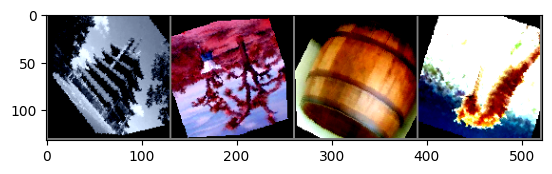

Labels: tensor([70, 54,  9, 83])


In [99]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import utils as vutils

# Create a data loader for the training set
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

# Get a batch of images and labels
images, labels = next(iter(train_loader))  # Change here: iterating over train_loader

# Display a few images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(vutils.make_grid(images)) # Change here: Using torchvision.utils.make_grid
print("Labels:", labels) # Removed slicing since we have the desired batch size


dataset loader for efficient batching

In [100]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Using pre-trained model
VGG19 model

In [101]:


import torch.nn as nn
from torchvision.models import vgg19

# Load the pre-trained VGG19 model
model = vgg19(pretrained=True)

# Adjust the final layer to output 101 classes
model.classifier[6] = nn.Linear(4096, 101)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 Model

In [102]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)

model.fc = nn.Linear(2048, 101) # Adjust the final layer for 101 classes

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet (efficientNet -B0)

In [103]:
from torchvision.models import efficientnet_b0
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(1280, 101) # Adjust the final layer for 101 classes

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the model
defining loss and optimizer

In [104]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train the model

In [105]:
from torch.utils.data import Dataset

class FilteredDataset(Dataset):
    def __init__(self, dataset, num_classes):
        self.dataset = dataset
        self.num_classes = num_classes
        self.valid_indices = [
            idx for idx, (_, label) in enumerate(dataset) if 0 <= label < num_classes
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        valid_idx = self.valid_indices[idx]
        return self.dataset[valid_idx]

# Replace `train_dataset` and `val_dataset` with filtered versions
filtered_train_dataset = FilteredDataset(train_data, num_classes=101)
filtered_val_dataset = FilteredDataset(val_data, num_classes=101)

# Create DataLoaders
train_loader = DataLoader(filtered_train_dataset, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(filtered_val_dataset, batch_size=10, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [106]:
for epoch in range(2):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

validate the model

In [107]:
model.eval()
with torch.no_grad():
     for images, labels in val_loader:
         outputs = model(images)
# Compute validation metrics

In [ ]:
# Previous code (loading dataset, defining model, etc.)

# Define Loss and Optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model
for epoch in range(2):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

# Validate the Model
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples * 100
print(f"Validation Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.4502641964688425


In [ ]:
# Verify the maximum label value
print("Max label value in dataset:", max([label for _, label in dataset]))


parameter tuning with grid search

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {
'lr': [0.1, 0.01, 0.001],
'batch_size': [16, 32, 64]
}
best_params = None
best_accuracy = 0
for params in ParameterGrid(param_grid):
   optimizer = optim.Adam(model.parameters(), lr=params['lr'])
   train_loader = DataLoader(train_data,
batch_size=params['batch_size'], shuffle=True)
# Perform training and validation here
# Compare and store the best parameters based on validation
#accuracy
print(f"Best Params: {best_params}")

Evaluating the model
evaluating on test data

In [ ]:
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
# Compute test metrics

confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_true = []
with torch.no_grad():
     for images, labels in test_loader:
         outputs = model(images)
         _, preds = torch.max(outputs, 1)
         y_pred.extend(preds.numpy())
         y_true.extend(labels.numpy())
cm = confusion_matrix(y_true, y_pred)
print(cm)

classification report

In [ ]:
from sklearn.metrics import classification_report

# Get the class names from the dataset
class_names = dataset.classes

# Now you can use class_names in the classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

Top-k Accuracy

In [ ]:
#Top-k Accuracy
#python
def top_k_accuracy(output, target, k=5):
   with torch.no_grad():
        max_k_preds = torch.topk(output, k, dim=1).indices
        correct = max_k_preds.eq(target.view(-1,1).expand_as(max_k_preds))
        return correct.any(dim=1).float().mean().item()

Per-class Accuracy

In [ ]:
#Per-Class Accuracy
#python
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
    print(f"Class {class_names[i]} Accuracy: {acc:.2f}")

t-SNE visualization

In [ ]:
#t-SNE Visualization
#python
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
features = []
labels_list = []
model.eval()
with torch.no_grad():
     for images, labels in test_loader:
         output = model(images)
         features.append(output)
         labels_list.append(labels)

features = torch.cat(features).numpy()
labels_list = torch.cat(labels_list).numpy()

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
c=labels_list, cmap='tab10')
plt.colorbar()
plt.show()

install grad-cam library

In [ ]:
#Part 6: Explainable AI (XAI) with Grad-CAM

#Install Grad-CAM Library
#Part 6: Explainable AI (XAI) with Grad-CAM

#Install Grad-CAM Library
#bash

!pip install grad-cam

apply grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch

# ... (rest of your imports) ...

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ... (previous code) ...

# Identify the last convolutional layer for EfficientNet
target_layers = [model.features[-1]]  # List of layers as required by the updated API

# Instantiate GradCAM without 'use_cuda'
cam = GradCAM(model=model, target_layers=target_layers)  # Remove use_cuda

# Process images through the test loader
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Generate Grad-CAM visualization
    grayscale_cam = cam(input_tensor=images, targets=None)
    for i in range(len(images)):
        # Denormalize the image before passing it to show_cam_on_image
        denormalized_image = images[i].permute(1, 2, 0).cpu().numpy()
        # Assuming your images were normalized using ImageNet stats
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        for j in range(3):  # Iterate through RGB channels
            denormalized_image[:, :, j] = (denormalized_image[:, :, j] * std[j]) + mean[j]

        # Clip pixel values to the [0, 1] range
        denormalized_image = np.clip(denormalized_image, 0, 1)

        cam_image = show_cam_on_image(
            denormalized_image,  # Pass the denormalized image
            grayscale_cam[i],
            use_rgb=True
        )

        plt.imshow(cam_image)
        plt.axis("off")
        plt.show()
    break